In [1]:
import glob,os,sys,sncosmo
from sntd import models,fitting,util,io
import sntd
from scipy import stats
from copy import copy,deepcopy
from astropy.table import vstack
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
reload(fitting)
#define which photometry we want to analyze (dolphot or hstphot)

photometry='dolphot'

if photometry=='dolphot':
    files=glob.glob(os.path.join('data','pat_refsdal',photometry,'stringent','*.dat'))
elif photometry=='hstphot':
    files=glob.glob(os.path.join('data','pat_refsdal',photometry,'*.dat'))
else:
    raise RuntimeError("Photometry not recognized.")

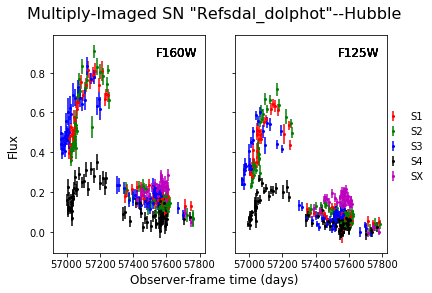

In [171]:
#Read in the data from pat
reload(io)
bands=[]
lcs=io.curveDict(telescopename='Hubble',object='Refsdal_'+photometry)
images=['s1','s2','s3','s4','sx']
for im in images:
    imTab=None
    for f in [x for x in files if im in x]:
        tab=ascii.read(f,comment='=')
        tab.remove_column('flag')
        tab.rename_column('mhjd','time')
        tab=tab[tab['time']>tab['time'][tab['flux']==np.max(tab['flux'])]-200]
        band=f[f.find('_'+photometry)-5:f.find('_'+photometry)]
        bands.append(band)
        tab['band']=band
        tab['zpsys']='ab'
        tab['zp']=25.0
        if imTab is None:
            imTab=copy(tab)
        else:
            imTab=vstack([imTab,tab])

    curve=sntd.table_factory(imTab,telescopename='Hubble',object=os.path.basename(f)[5:7].upper())
    lcs.add_curve(curve)
lcs.plot_object(showfig=True,filename='mySN_orig')
plt.close()


In [221]:
def chisquare(observed_values,expected_values,errors,df):
    z = (observed_values - expected_values) / errors 
    chi2 = np.sum(z ** 2)
    chi2dof = chi2/df

    return chi2, chi2dof

def print_td_mu(curveDict):
    for b in np.sort(curveDict.keys()):
        for d in np.sort(curveDict[b].images.keys()):
            tempTable=curveDict[b].images[d].table[curveDict[b].images[d].table['band']==b]
            dof=curveDict[b].images[d].fits.res.ndof
            chisq,red_chisq=chisquare(tempTable['flux'],
                            curveDict[b].images[d].fits.model.bandflux(b,tempTable['time'],zp=25.0,zpsys='ab'),
                            tempTable['fluxerr'],df=dof)#
            sigma = np.sqrt(2. / dof)
            nsig = (red_chisq - 1) / sigma
            print('Band %s, Image %s: Reduced Chisq=%f, Nsig=%f'%(b,d,red_chisq,nsig))#,stats.chi2.sf(red_chisq,dof)
        delays,delay_errs=curveDict[b].time_delays,curveDict[b].time_delay_errors
        mags,mag_errs=curveDict[b].magnifications,curveDict[b].magnification_errors
        print('     Time Delays: ')
        for d in np.sort(delays.keys()):
            print('          S1%s=%.2f±%.2f'%(d,delays[d],delay_errs[d]))
        print('     Magnifications: ')
        for d in np.sort(mags.keys()):
            print('          S1%s=%.2f±%.2f'%(d,mags[d],mag_errs[d]))

In [192]:
#Fit with new pierel model first
reload(models)
reload(fitting)

my_curves=dict([])
#guess={'F160W':{'S1':57148,'S2':57165,'S3':57114,'S4':57163},'F125W':{'S1':57142,'S2':57162,'S3':57097,'S4':57160}}
guess={'F160W':{'S1':57152,'S2':57172,'S3':57107,'S4':57169,'SX':57541},
       'F125W':{'S1':57145,'S2':57168,'S3':57100,'S4':57163,'SX':57526}}
for b in lcs.bands:
    print(b)
    bds={'t0':(-3,3),'amplitude':(.75,1.35),'k':(.2,.75),'sigma':(75,120),'s':(0,.2)}

    temp=fitting.fit_data(lcs,bands=[b],snType='II',models=['PierelSource'],params=['k','sigma','amplitude','t0','s'],flip=False,t0_guess=guess[b],
                               bounds=bds,combined_or_separate='separate')
    my_curves[b]=copy(temp)

F160W
('S3', 8.549512403440872)
('S2', 8.03975524341945)
('S1', 8.225293641999926)
('SX', 4.795500346635299)
('S4', 6.148108538252245)
amplitude
Image S3:  <amplitude> = 6.302153e-01 +- 5.20e-03
Image S2:  <amplitude> = 7.628323e-01 +- 1.12e-02
Image S1:  <amplitude> = 6.657817e-01 +- 1.26e-02
Image SX:  <amplitude> = 2.266441e-01 +- 8.41e-03
Image S4:  <amplitude> = 2.715094e-01 +- 6.34e-03
s
Image S3:  <s> = 1.585434e-01 +- 5.41e-03
Image S2:  <s> = 1.308755e-01 +- 5.45e-03
Image S1:  <s> = 1.547054e-01 +- 6.31e-03
Image SX:  <s> = 1.432615e-02 +- 8.88e-03
Image S4:  <s> = 5.800973e-02 +- 7.26e-03
sigma
  <sigma> = 9.952e+01 +- 9.764e+00
k
  <k> = 4.242e-01 +- 1.815e-01
t0
Image S3:  <t0> = 5.710806e+04 +- 6.04e-01
Image S2:  <t0> = 5.717345e+04 +- 1.95e+00
Image S1:  <t0> = 5.715302e+04 +- 1.37e+00
Image SX:  <t0> = 5.754120e+04 +- 1.67e+00
Image S4:  <t0> = 5.716774e+04 +- 1.66e+00
('S1', 1.9655013106197143, 1.1861254726023398e-05, 117.93007863718286, 60)
('S2', 3.5655190921855153,

In [193]:
import math
reload(fitting)

#print(my_curves['F160W'].images['S1'].fits.final_errs)
#print(my_curves['F160W'].images['S2'].fits.final_errs)

print_td_mu(my_curves)
    
    
    

Band F125W, Image S1: Reduced Chisq=1.613401, Nsig=3.415273
Band F125W, Image S2: Reduced Chisq=3.381814, Nsig=13.367898
Band F125W, Image S3: Reduced Chisq=3.003099, Nsig=11.242367
Band F125W, Image S4: Reduced Chisq=2.344334, Nsig=7.663884
Band F125W, Image SX: Reduced Chisq=1.439400, Nsig=1.811692
     Time Delays: 
          S1S1=0.00±0.00
          S1S2=-22.08±1.23
          S1S3=42.87±1.40
          S1S4=-18.74±2.02
          S1SX=-382.01±1.95
     Magnifications: 
          S1S1=1.00±0.00
          S1S2=1.14±0.02
          S1S3=0.89±0.02
          S1S4=0.38±0.02
          S1SX=0.30±0.01
Band F160W, Image S1: Reduced Chisq=1.965501, Nsig=5.288268
Band F160W, Image S2: Reduced Chisq=3.565519, Nsig=14.168542
Band F160W, Image S3: Reduced Chisq=1.726616, Nsig=3.946536
Band F160W, Image S4: Reduced Chisq=1.632458, Nsig=3.492865
Band F160W, Image SX: Reduced Chisq=1.239212, Nsig=0.828655
     Time Delays: 
          S1S1=0.00±0.00
          S1S2=-20.42±2.38
          S1S3=44.97±1.50
 

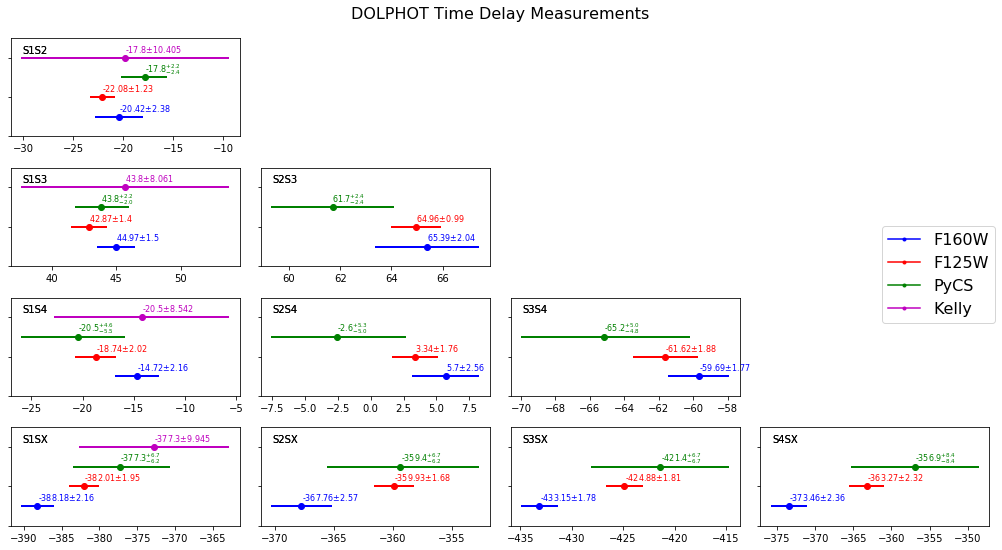

In [207]:
from sntd import plotting
from matplotlib.lines import Line2D
reload(plotting)
plt.clf()
pycs={'S1S2':-17.8,'S1S3':43.8,'S1S4':-20.5,'S2S3':61.7,'S2S4':-2.6,
      'S3S4':-65.2,'S1SX':-377.3,'S2SX':-359.4,'S3SX':-421.4,'S4SX':-356.9}
pycs_pos={'S1S2':2.2,'S1S3':2.2,'S1S4':4.6,'S2S3':2.4,'S2S4':5.3,
          'S3S4':5.0,'S1SX':6.7,'S2SX':6.7,'S3SX':6.7,'S4SX':8.4}
pycs_neg={'S1S2':2.4,'S1S3':2.0,'S1S4':5.5,'S2S3':2.4,'S2S4':5.0,
          'S3S4':4.8,'S1SX':6.2,'S2SX':6.2,'S3SX':6.7,'S4SX':8.4}
pat={'S1S2':-19.8,'S1S3':45.685,'S1S4':-14.239,'S1SX':-372.768}
pat_pos={'S1S2':10.405,'S1S3':8.061,'S1S4':8.542,'S1SX':9.945}
pat_neg={'S1S2':10.405,'S1S3':8.061,'S1S4':8.542,'S1SX':9.945}

def plot_separate_res(curveDict):
    colors=['b','r']
    ax=None
    fig=None
    offset=1
    for i in range(len(curveDict.keys())):
        if ax is None:
            ax,fig=plotting.plotTimeDelays(curveDict[curveDict.keys()[i]],band=curveDict.keys()[i],
                                           offset=offset,color=colors[i],showfig=False,savefig=False)
        else:
            ax,fig=plotting.plotTimeDelays(curveDict[curveDict.keys()[i]],band=curveDict.keys()[i],
                                    color=colors[i],offset=offset,fig=fig,ax=ax,showfig=False,savefig=False)
        offset+=1

    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            delay='S'+str(j+1)+'S'+str(i+2) if i+2<5 else 'S'+str(j+1)+'SX'
            if j<=i:
                ax[i][j].errorbar(pycs[delay],offset,xerr=[[pycs_neg[delay]],[pycs_pos[delay]]],
                                 fmt='.',color='g',linewidth=2,markersize=12)
                #ax[i][j].set_ylim((0,offset+1))
                ax[i][j].annotate(str(pycs[delay])+'$^{+'+str(pycs_pos[delay])+'}_{-'+str(pycs_neg[delay])+'}$',
                                 size=8,xy=(.9999*pycs[delay],offset+.3),xycoords='data',color='g')
            if j==0:
                ax[i][j].errorbar(pat[delay],offset+1,xerr=[[pat_neg[delay]],[pat_pos[delay]]],
                                 fmt='.',color='m',linewidth=2,markersize=12)
                
                ax[i][j].annotate(str(pycs[delay])+'$\pm$'+str(pat_pos[delay]),
                                 size=8,xy=(.9999*pat[delay],offset+1.3),xycoords='data',color='m')
            ax[i][j].set_ylim((0,offset+2))
    fig.suptitle(photometry.upper()+' Time Delay Measurements',size=16)
    custom_lines=[Line2D([0],[0],marker='.',color=colors[i]) for i in range(len(colors))]
    custom_lines.append(Line2D([0],[0],marker='.',color='g'))
    custom_lines.append(Line2D([0],[0],marker='.',color='m'))
    leg=plt.figlegend(custom_lines,np.append(curveDict.keys(),['PyCS','Kelly']),loc='center right',fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    #fig.figsize=(15,15)
plot_separate_res(my_curves)
plt.show()
plt.close()
        

In [229]:
#Fit with new pierel model to combined lc
reload(fitting)
from sntd import io
reload(io)
curves=dict([])
guess={'F160W':57152,'F125W':57145}

for b in lcs.bands:
    compFunc,errors=fitting.create_composite_model(my_curves[b],b,'S1')
    #print(type(my_curves[b]))
    #temp=io.curveDict(my_curves[b])#io._sntd_deepcopy(deepcopy(my_curves[b]))
    temp=io._sntd_deepcopy(deepcopy(lcs))
    temp.combine_curves(tds=my_curves[b].time_delays,mus=my_curves[b].magnifications)
    temp.plot_object(combined=True,filename=b+'_mySN',bands=set([b]))
    temp.combined.table.sort('time')
    #fig=plt.figure()
    #ax=fig.gca()
    #ax.scatter(temp.combined.table['time'],temp.combined.table['flux'])
    #ax.plot(temp.combined.table['time'],compFunc(temp.combined.table['time']))
    #plt.show()
    #sys.exit()
    td_bound=np.max(my_curves[b].time_delay_errors.values())
    mu_bound=np.max(my_curves[b].magnification_errors.values())
    #temp.images['S1'].fits=fitting.newDict()
    #temp.images['S1'].fits.model=copy(my_curves[b].images['S1'].fits.model)
    bds={'t0':(-5,5),'amplitude':(.75,1.35),'k':(.2,.75),'sigma':(75,120),'s':(0,.2)}
    #(copy(my_curves[b].images['S1'].fits.model),copy(my_curves[b].images['S1'].fits.res))
    temp=fitting.fit_data(temp,bands=[b],refModel=compFunc,
                               snType='II',models=['PierelSource'],params=['k','sigma','amplitude','t0','s'],
                               t0_guess=guess[b],combinedError=errors,bounds=bds,
                               combinedGrids={'td':(-5,5),'mu':(-.1,.1)},
                               combined_or_separate='combined')
    curves[b]=copy(temp)

In [230]:
for b in np.sort(curves.keys()):
    tempTable=curves[b].combined.table[curves[b].combined.table['band']==b]
    tempTable.sort('time')
    dof=len(curves[b].combined.table)-1#fits.res.ndof
    chisq,red_chisq=chisquare(tempTable['flux'],
                    curves[b].combined.fits.model(tempTable['time']),
                    tempTable['fluxerr'],df=dof)#
    sigma = np.sqrt(2. / dof)
    nsig = (red_chisq - 1) / sigma
    print('Band %s, Image %s: Reduced Chisq=%f, Nsig=%f'%(b,d,red_chisq,nsig))#,stats.chi2.sf(red_chisq,dof)
    delays,delay_errs=curves[b].combined.time_delays,curves[b].combined.time_delay_errors
    mags,mag_errs=curves[b].combined.magnifications,curves[b].combined.magnification_errors
    print('     Time Delays: ')
    for d in np.sort(delay_errs.keys()):
        print('          S1%s=%.2f±%.2f'%(d,delays[d],delay_errs[d]))
    print('     Magnifications: ')
    for d in np.sort(mag_errs.keys()):
        print('          S1%s=%.2f±%.2f'%(d,mags[d],mag_errs[d]))
    

Band F125W, Image SX: Reduced Chisq=3.577362, Nsig=44.678398
     Time Delays: 
          S1S2=-22.03±2.86
          S1S3=42.83±2.94
          S1S4=-19.18±2.97
          S1SX=-381.91±2.87
     Magnifications: 
          S1S1=1.00±0.00
          S1S2=1.14±0.05
          S1S3=0.90±0.06
          S1S4=0.42±0.03
          S1SX=0.31±0.03
Band F160W, Image SX: Reduced Chisq=2.841413, Nsig=31.920779
     Time Delays: 
          S1S2=-20.53±2.91
          S1S3=45.15±2.86
          S1S4=-14.85±3.01
          S1SX=-388.31±2.94
     Magnifications: 
          S1S1=1.00±0.00
          S1S2=1.15±0.05
          S1S3=0.97±0.05
          S1S4=0.43±0.04
          S1SX=0.33±0.03


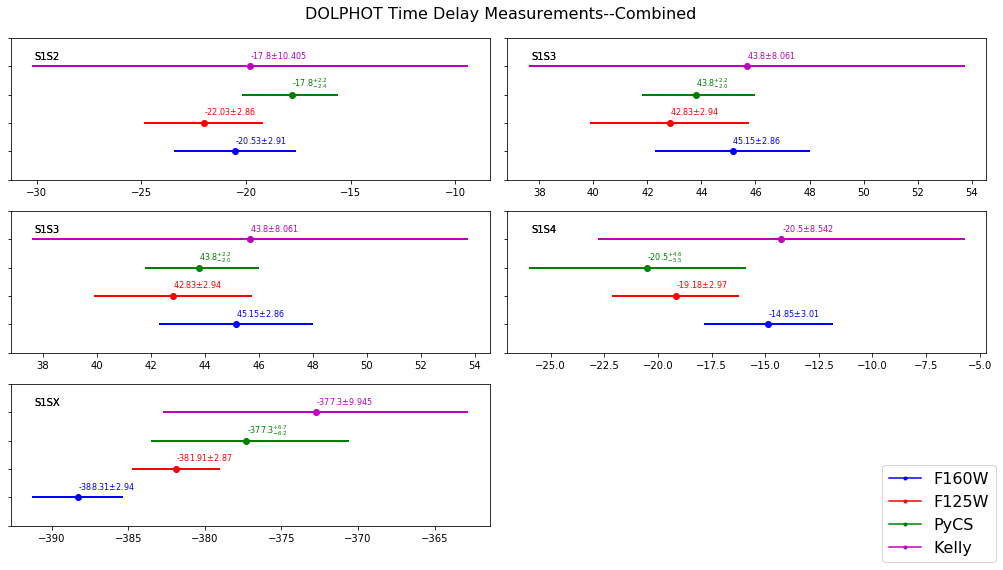

In [286]:

reload(io)
def plot_combined_fit(curveDict,fitter):
    for b in curves.keys():
        temp=io._sntd_deepcopy(deepcopy(lcs))
        temp.combine_curves(tds=curveDict[b].combined.time_delays,mus=curveDict[b].combined.magnifications)
        temp.combined.fits=fitting.newDict()
        temp.combined.fits.model=copy(curveDict[b].combined.fits.model)
        temp.plot_object(bands=set([b]),showmodel=True,combined=True,filename=fitter+'_mySN_'+b+'_fit')
    plt.close()
    fig,ax=plt.subplots(nrows=3,ncols=2,sharex=False,sharey=True,figsize=(14,8))
    offset=1
    colors={'F160W':'b','F125W':'r'}
    for b in curves.keys():
        for i in range(3):
            for j in range(2):
                delay='S1S'+str(i+j+2) if i<2 else 'S1SX'
                ax[i][j].errorbar(curveDict[b].combined.time_delays[delay[-2:]],offset,
                                          xerr=curveDict[b].combined.time_delay_errors[delay[-2:]],
                                          fmt='.',color=colors[b],linewidth=2,markersize=12)
                ax[i][j].annotate(delay,size=10,xy=(0.05,.85),xycoords='axes fraction')
                ax[i][j].annotate(str(np.round(curveDict[b].combined.time_delays[delay[-2:]],2))+'$\pm$'+str(np.round(curveDict[b].combined.time_delay_errors[delay[-2:]],2)),
                                  size=8,xy=(.9999*(curveDict[b].combined.time_delays[delay[-2:]]),offset+.3),xycoords='data',color=colors[b])
                #ax[i][j].set_xlim((.8*(lcs.time_delays['S'+str(i+2)]-lcs.time_delays['S'+str(j+1)]),1.2*(lcs.time_delays['S'+str(i+2)]-lcs.time_delays['S'+str(j+1)])))

        offset+=1
    for i in range(3):
        for j in range(2):
            delay='S1S'+str(i+j+2) if i<2 else 'S1SX'
            ax[i][j].set_ylim((0,offset+1))
            ax[i][j].tick_params(axis='y',labelleft='off')
            ax[i][j].errorbar(pycs[delay],offset,xerr=[[pycs_neg[delay]],[pycs_pos[delay]]],
                         fmt='.',color='g',linewidth=2,markersize=12)
            #ax[i][j].set_ylim((0,offset+1))
            ax[i][j].annotate(str(pycs[delay])+'$^{+'+str(pycs_pos[delay])+'}_{-'+str(pycs_neg[delay])+'}$',
                             size=8,xy=(.9999*pycs[delay],offset+.3),xycoords='data',color='g')

            ax[i][j].errorbar(pat[delay],offset+1,xerr=[[pat_neg[delay]],[pat_pos[delay]]],
                             fmt='.',color='m',linewidth=2,markersize=12)

            ax[i][j].annotate(str(pycs[delay])+'$\pm$'+str(pat_pos[delay]),
                             size=8,xy=(.9999*pat[delay],offset+1.3),xycoords='data',color='m')
            ax[i][j].set_ylim((0,offset+2))
        fig.suptitle(photometry.upper()+' Time Delay Measurements',size=16)

    fig.delaxes(ax[2][1])
    fig.suptitle(photometry.upper()+' Time Delay Measurements--Combined',size=16)
    custom_lines=[Line2D([0],[0],marker='.',color=colors[b]) for b in curves.keys()]
    custom_lines.append(Line2D([0],[0],marker='.',color='g'))
    custom_lines.append(Line2D([0],[0],marker='.',color='m'))
    leg=plt.figlegend(custom_lines,np.append(curveDict.keys(),['PyCS','Kelly']),loc='lower right',fontsize=16)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_combined_fit(curves,'pierel')
plt.show()
plt.close()
    

In [250]:
#fit to bazin 2009 model separately
reload(fitting)
reload(models)
baz_curves=dict([])

#guess={'F160W':{'S1':57153,'S2':57172,'S3':57112,'S4':57162,'SX':57537},
#       'F125W':{'S1':57151,'S2':57147,'S3':57093,'S4':57150,'SX':57535}}

#guess={'F160W':{'S1':57167,'S2':57183,'S3':57121,'S4':57185,'SX':57542},
#       'F125W':{'S1':57157,'S2':57184,'S3':57096,'S4':57166,'SX':57534}}
guess={'F160W':{'S1':57165,'S2':57173,'S3':57121,'S4':57162,'SX':57550},
       'F125W':{'S1':57143,'S2':57152,'S3':57096,'S4':57150,'SX':57534}}
for b in lcs.bands:
    print(b)
    if b=='F160W':
        bds={'t0':(-10,10),'amplitude':(.75,1.25),'fall':(70,100),'rise':(30,55),'B':(0,.25)}
    else:
        bds={'t0':(-10,10),'amplitude':(.75,1.25),'fall':(70,100),'rise':(30,55),'B':(0,.25)}
    temp=fitting.fit_data(lcs,bands=[b],snType='II',models=['BazinSource'],params=['amplitude','B','fall','rise','t0'],
                            flip=False,t0_guess=guess[b],bounds=bds,combined_or_separate='separate')
    baz_curves[b]=copy(temp)

F160W
('S3', 9.278259915217461)
('S2', 8.604194035509025)
('S1', 8.478796292808013)
('SX', 5.675660924925458)
('S4', 6.517509945340954)
rise
  <rise> = 4.595e+01 +- 4.684e+00
B
Image S3:  <B> = 1.503861e-01 +- 6.50e-03
Image S2:  <B> = 1.072291e-01 +- 7.88e-03
Image S1:  <B> = 1.467779e-01 +- 6.83e-03
Image SX:  <B> = 1.366599e-02 +- 8.16e-03
Image S4:  <B> = 5.369584e-02 +- 6.19e-03
amplitude
Image S3:  <amplitude> = 6.349751e-01 +- 8.82e-03
Image S2:  <amplitude> = 8.016646e-01 +- 1.59e-02
Image S1:  <amplitude> = 6.894724e-01 +- 1.60e-02
Image SX:  <amplitude> = 2.268262e-01 +- 8.04e-03
Image S4:  <amplitude> = 2.731600e-01 +- 8.20e-03
t0
Image S3:  <t0> = 5.712395e+04 +- 4.16e+00
Image S2:  <t0> = 5.717384e+04 +- 5.07e+00
Image S1:  <t0> = 5.716618e+04 +- 4.80e+00
Image SX:  <t0> = 5.755208e+04 +- 5.24e+00
Image S4:  <t0> = 5.716117e+04 +- 5.28e+00
fall
  <fall> = 8.193e+01 +- 1.004e+01
('S1', 2.053922813832111, 2.88651261707181e-06, 123.23536882992666, 60)
('S2', 3.981993102348128

In [251]:
print_td_mu(baz_curves)


Band F125W, Image S1: Reduced Chisq=1.799635, Nsig=4.452179
Band F125W, Image S2: Reduced Chisq=3.225143, Nsig=12.488586
Band F125W, Image S3: Reduced Chisq=3.461520, Nsig=13.815248
Band F125W, Image S4: Reduced Chisq=2.308640, Nsig=7.460394
Band F125W, Image SX: Reduced Chisq=1.586088, Nsig=2.416505
     Time Delays: 
          S1S1=0.00±0.00
          S1S2=-5.64±5.12
          S1S3=51.54±5.32
          S1S4=6.31±4.00
          S1SX=-383.65±5.94
     Magnifications: 
          S1S1=1.00±0.00
          S1S2=1.15±0.03
          S1S3=0.90±0.03
          S1S4=0.37±0.02
          S1SX=0.29±0.01
Band F160W, Image S1: Reduced Chisq=2.053923, Nsig=5.772573
Band F160W, Image S2: Reduced Chisq=3.981993, Nsig=16.468595
Band F160W, Image S3: Reduced Chisq=1.542775, Nsig=2.948021
Band F160W, Image S4: Reduced Chisq=1.628058, Nsig=3.468566
Band F160W, Image SX: Reduced Chisq=1.281892, Nsig=0.976504
     Time Delays: 
          S1S1=0.00±0.00
          S1S2=-7.66±6.98
          S1S3=42.22±6.35
     

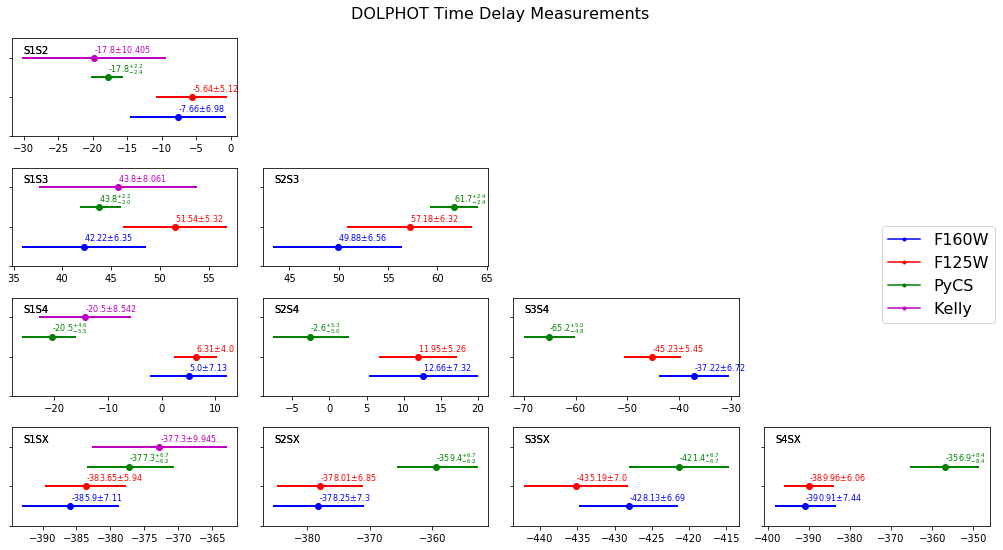

In [252]:
plot_separate_res(baz_curves)
plt.show()
plt.close()

In [269]:
#Fit with bazin model to combined lc
reload(fitting)
reload(models)
from sntd import io
reload(io)
baz_comb=dict([])
guess={'F160W':57165,'F125W':57143}

for b in lcs.bands:
    compFunc2,errors=fitting.create_composite_model(baz_curves[b],b,'S1')
    #print(type(my_curves[b]))
    #temp=io.curveDict(my_curves[b])#io._sntd_deepcopy(deepcopy(my_curves[b]))
    temp=io._sntd_deepcopy(deepcopy(lcs))
    temp.combine_curves(tds=baz_curves[b].time_delays,mus=baz_curves[b].magnifications)
    temp.plot_object(combined=True,filename='bazin_'+b+'_mySN',bands=set([b]))
    temp.combined.table.sort('time')
    bds={'t0':(-5,5),'amplitude':(.75,1.25),'fall':(70,100),'rise':(30,55),'B':(0,.25)}
    temp=fitting.fit_data(temp,bands=[b],refModel=compFunc2,
                               snType='II',models=['BazinSource'],params=['amplitude','B','fall','rise','t0'],
                               t0_guess=guess[b],combinedError=errors,bounds=bds,
                               combinedGrids={'td':(-15,15),'mu':(-.2,.2)},
                               combined_or_separate='combined')
    baz_comb[b]=copy(temp)
    

In [270]:
for b in np.sort(baz_comb.keys()):
    tempTable=baz_comb[b].combined.table[baz_comb[b].combined.table['band']==b]
    tempTable.sort('time')
    dof=len(baz_comb[b].combined.table)-1#fits.res.ndof
    chisq,red_chisq=chisquare(tempTable['flux'],
                    baz_comb[b].combined.fits.model(tempTable['time']),
                    tempTable['fluxerr'],df=dof)#
    sigma = np.sqrt(2. / dof)
    nsig = (red_chisq - 1) / sigma
    print('Band %s, Image %s: Reduced Chisq=%f, Nsig=%f'%(b,d,red_chisq,nsig))#,stats.chi2.sf(red_chisq,dof)
    delays,delay_errs=baz_comb[b].combined.time_delays,baz_comb[b].combined.time_delay_errors
    mags,mag_errs=baz_comb[b].combined.magnifications,baz_comb[b].combined.magnification_errors
    print('     Time Delays: ')
    for d in np.sort(delay_errs.keys()):
        print('          S1%s=%.2f±%.2f'%(d,delays[d],delay_errs[d]))
    print('     Magnifications: ')
    for d in np.sort(mag_errs.keys()):
        print('          S1%s=%.2f±%.2f'%(d,mags[d],mag_errs[d]))
        

Band F125W, Image SX: Reduced Chisq=4.776663, Nsig=65.468214
     Time Delays: 
          S1S2=-8.75±8.18
          S1S3=49.57±8.44
          S1S4=1.03±7.67
          S1SX=-382.14±8.61
     Magnifications: 
          S1S1=1.00±0.00
          S1S2=1.13±0.10
          S1S3=0.93±0.09
          S1S4=0.41±0.05
          S1SX=0.30±0.02
Band F160W, Image SX: Reduced Chisq=3.231974, Nsig=38.691124
     Time Delays: 
          S1S2=-9.10±8.61
          S1S3=42.81±8.74
          S1S4=1.27±7.95
          S1SX=-386.66±8.93
     Magnifications: 
          S1S1=1.00±0.00
          S1S2=1.16±0.10
          S1S3=1.01±0.07
          S1S4=0.41±0.05
          S1SX=0.33±0.03


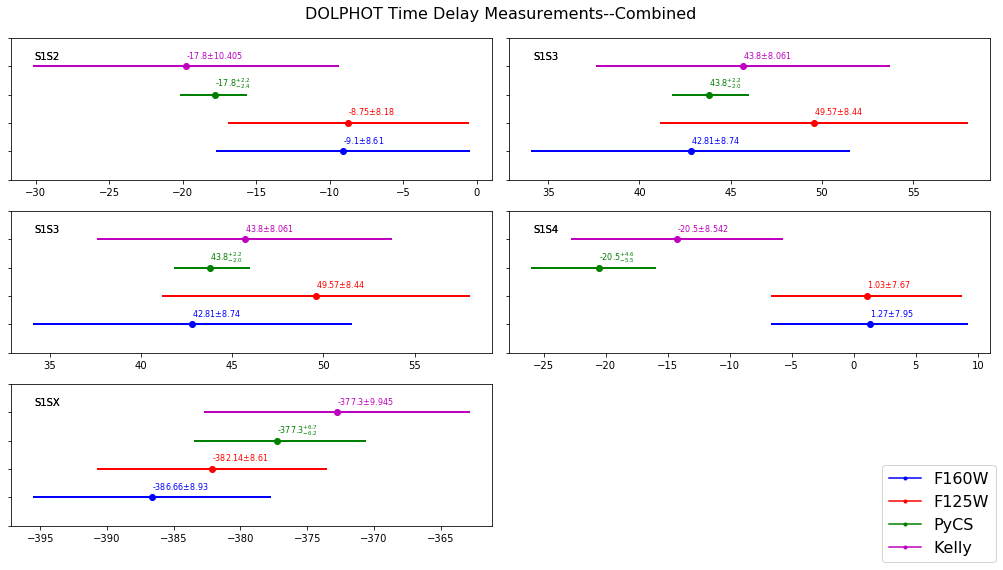

In [287]:
plot_combined_fit(baz_comb,'bazin')
plt.show()
plt.close()




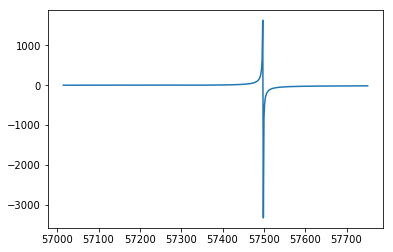

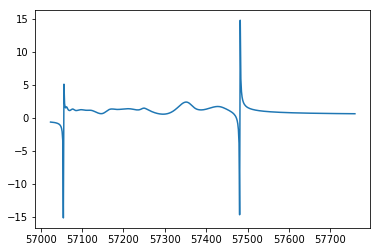

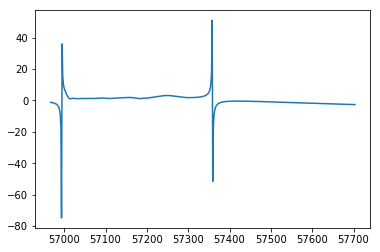

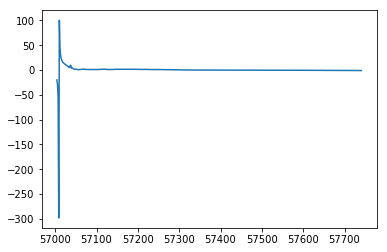

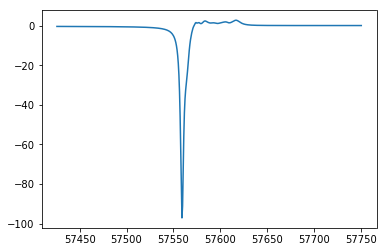

S1
[57496.66736215]
0
S2
[57482.83398372]
-229.1642129869615
S3
[57357.599954]
-322.29762237783507
S4
[57010.69088342]
-488.19683674283806
SX
[57616.80138775]
90.23388613414863
{'S3': -322.29762237783507, 'S2': -229.1642129869615, 'S1': 0.0, 'SX': 90.23388613414863, 'S4': -488.19683674283806}


In [285]:
#fitting color curves
plt.close()
from sntd import util
reload(util)
temp=io._sntd_deepcopy(deepcopy(lcs))
delays=util.colorFit(temp)
print(delays)